In [1]:
from lightgbm import LGBMRegressor, LGBMClassifier
import shap
from umap import UMAP
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import seaborn as sns

from modelling_functions import ModelTrainer, split_data, validation

import os

In [2]:
data_path = os.path.join('..','data','01_raw','data.csv')
df = pd.read_csv(data_path)

In [3]:
data_path = os.path.join('..','data','01_raw','data.csv')
df = pd.read_csv(data_path)

df['municipio']=df['municipio'].str.replace(' ','_')
df['bairro']=df['bairro'].str.replace(' ','_')
df['bairro'] = df['bairro'].fillna('')
df['municipio+bairro'] = df['municipio']+'_'+df['bairro']
df['tier_por_porte'] = (df['tier']+1)/(df['porte']+1)

df = df.rename(columns={'stone_tpv_acquirer_total':'target'})

In [4]:
conditions = [
    (df['target'] <= 1000),
    (df['target'] <= 10000),
    (df['target'] <= 50000),
    (df['target'] <= 100000),
    (df['target'] > 100000)
]

values = [0, 1, 2, 3, 4]

# Criar a coluna 'target_class' com base nas condições e valores
df['target_class'] = np.select(conditions, values)
df.drop(columns=['municipio','bairro'], inplace=True)

In [5]:
df['target_class'].value_counts()

target_class
2    56735
1    28047
3     8256
0     6962
Name: count, dtype: int64

In [6]:
le = LabelEncoder()

for col in ['uf','municipio+bairro']:
    df[col] = le.fit_transform(df[col])

In [7]:
categorical_list = list(df.drop(columns=['capital_social','total_estab','target_class','target']))
df[categorical_list] = df[categorical_list].astype('category')
df['target_class'] = df['target_class'].astype('category')

In [8]:
X, X_train, X_val, X_test, y, y_train, y_val, y_test = split_data(df.drop(columns='target'),'target_class')

In [9]:
# def convert_regression_to_classification(X, y, n_components=2, n_neighbors=200, min_dist=0, eps=1.5, min_samples=20, max_depth=2):
# Train LGBMRegressor
m = ModelTrainer(LGBMClassifier(n_estimators=700))
m.train(X, y)



    # for cluster in np.unique(s_labels):
    #     # create target variable for individual cluster
    #     yc = (s_labels == cluster) * 1
    #     # use SkopeRules to identify rules with a maximum of two comparison terms
    #     sr = SkopeRules(max_depth=max_depth).fit(X, yc)
    #     # print best decision rule
    #     print(cluster, sr.rules_[0][0])
    #     # print precision and recall of best decision rule
    #     print(f"Precision: {sr.rules_[0][1][0]:.2f}", f"Recall: {sr.rules_[0][1][1]:.2f}")

# Example usage:
# convert_regression_to_classification(X, y, n_components=2, n_neighbors=200, min_dist=0, eps=1.5, min_samples=20, max_depth=2)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 13
[LightGBM] [Info] Start training from score -2.665401
[LightGBM] [Info] Start training from score -1.268130
[LightGBM] [Info] Start training from score -0.567799
[LightGBM] [Info] Start training from score -2.497384


LGBMClassifier(n_estimators=2000)

In [10]:
validation(X,y,m,'total',multi=True)

,Accuracy,Precision,Recall,F1 Score,ROC-AUC
total,0.886186,0.888379,0.886186,0.88515,0.968751


In [11]:
explainer = shap.TreeExplainer(m.model, random_state=42)
shap_values = explainer(X)

In [ ]:
c = ["#d45087"] * len(y)  # pink
for i in range(len(y)):
    if y[i] == 1:
        c[i] = "#003f5c"

In [10]:
# Compute 2D embedding of raw variable values
X_2d = UMAP(n_components=2,
            n_neighbors=200,
            min_dist=0).fit_transform(X)

<Axes: xlabel='A', ylabel='B'>

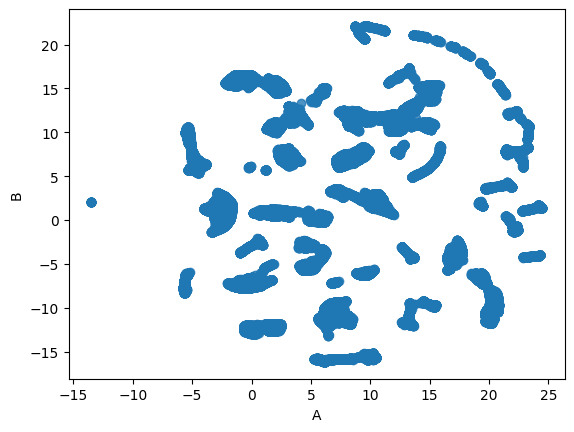

In [11]:
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(X_2d, columns=["A", "B"]),
    fit_reg=False,
)

In [23]:

# Compute 2D embedding of SHAP values
s_2d = UMAP(n_components=2,
            n_neighbors=200,
            min_dist=0).fit_transform(shap_values)

In [13]:
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(s_2d, columns=["A", "B"]),
    fit_reg=False,
)

NameError: name 's_2d' is not defined

In [14]:
# Identify clusters using DBSCAN
s_2d_labels = DBSCAN(eps=1.5, min_samples=100).fit(s_2d).labels_
for cluster, count in pd.Series(s_2d_labels).value_counts().sort_index().items():
    print(cluster, count, s_2d[s_2d_labels == cluster].mean(0))

0 15780 [ 2.9673572 15.861466 ]
1 9064 [14.5138235  3.4427538]
2 26378 [ 1.348236  -3.5672636]
3 1987 [3.7425976 5.8769813]
4 16377 [-4.665528 13.575824]
5 414 [12.215497  6.165682]


In [15]:
import matplotlib.pyplot as plt

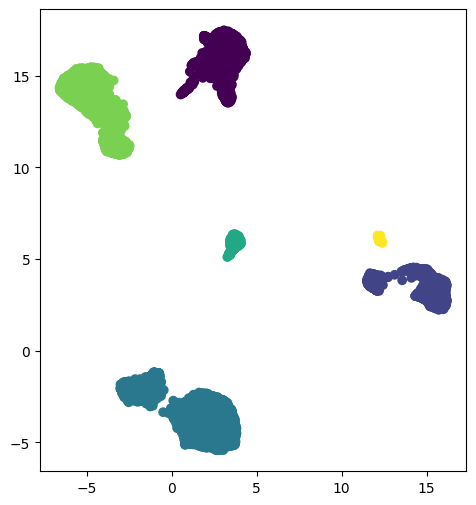

In [16]:
fig, ax = plt.subplots(figsize=(5.5, 6))
ax.scatter(s_2d[:, 0], s_2d[:, 1], c=s_2d_labels)

In [55]:
df_sv = pd.DataFrame(shap_values.values)
df_sv.columns = [f"feat{n}" for n in range(X.shape[1])]
df_sv["y"] = y
df_sv["variable value"] = "shap"

In [56]:
df_raw = pd.DataFrame(X)
df_raw.columns = [f"feat{n}" for n in range(X.shape[1])]
df_sv["y"] = y
df_raw["variable value"] = "raw"

In [57]:
df_sv['label'] = s_2d_labels
df_raw['label'] = s_2d_labels

In [76]:
X_new = X.copy()
X_new['label'] = s_2d_labels

In [78]:
m.train(X_new,y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1302
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 14
[LightGBM] [Info] Start training from score 39031.974070


LGBMRegressor(n_estimators=2000)

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
X_new_train, X_new_val, y_new_train, y_new_val = train_test_split(X_new, y, test_size=0.5)

In [87]:
m2 = ModelTrainer(LGBMRegressor())

In [89]:
m2.train(X_new_train,y_new_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 14
[LightGBM] [Info] Start training from score 39346.474483


LGBMRegressor()

In [1]:
pd.concat([X_new,y])

NameError: name 'pd' is not defined